# Machine Learning Programming Assignment 2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from sklearn import linear_model
from sklearn.datasets import make_regression

from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV,ElasticNet, LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from matplotlib import pyplot
import seaborn as sns

from sklearn.svm import LinearSVC

import warnings
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import ShuffleSplit


# Part 1 Wine

In [3]:
#Read csv files
red = pd.read_csv("winequality-red.csv", delimiter=';')
white = pd.read_csv("winequality-white.csv", delimiter=';')

In [4]:
#Substitute spaces in column names for _
red.columns = red.columns.str.replace(' ','_')
white.columns = red.columns.str.replace(' ','_')

## Logistic Regression

In [5]:
# The Logistic Regression model

def wine_logistic_regression(df):
    ''' Logistic Regression using MinMaxScaler, GridSearchCV, and cross-validation for the wine datasets. 
    
    Prints the training and test set scores. 
    
    Args:
        df : pandas.core.frame.DataFrame [the wine dataset that you want to use]
    
    Returns:
        Does not return anything.  
    '''
    # Feature variables
    X = df.drop('quality',axis = 1)
    y = df['quality']
    
    # Splitting data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    
    # Creating a pipeline
    pipe = Pipeline([("scaler", MinMaxScaler()), ("lr", LogisticRegression(max_iter = 10000))]) 
    
    # Grid search
    param_grid = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100]}
    cv = ShuffleSplit(n_splits=5, test_size=0.25)  
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)
    # Fitting data into the model
    grid.fit(X_train, y_train) 
    
    # Evaluate a score by cross-validation and report it
    cv_score = np.mean(cross_val_score(grid,X_train,y_train, cv=cv))
    print("The training score by cross-validation.: {:.4f}".format(cv_score))
    # Report the training set and test set scores
    print('Training set score: {:.4f}'.format(grid.score(X_train,y_train)))
    print('Test set score: {:.4f}'.format(grid.score(X_test, y_test)))

In [6]:
wine_logistic_regression(red)

The training score by cross-validation.: 0.6040
Training set score: 0.6180
Test set score: 0.5550


In [7]:
wine_logistic_regression(white)

The training score by cross-validation.: 0.5452
Training set score: 0.5440
Test set score: 0.5363


1. As the quality of wine is an integer (not continuous) from 1 to 10, treating quality as a categorical object gives a better prediction.

2. We use logistics regression as a classifier to solve this muti-classification problem. However, logistics regression is usually used for binary classification. Moreover, the logistic regression assumes a linear relationship between the features and the target values, while the linear relationship is not significant in our case (see Assignment 1).

3. For classification problems, each category does not have a natural order. However, there is an order to the quality of the wine. This may lead us to miss some useful information.

# Part 2 Bank

## Data Preprocessing

In [8]:
#Read csv files
train = pd.read_csv("train.csv",na_values='unknown') # Treating the 'unknown' as NaN
test = pd.read_csv("test.csv", na_values='unknown')
test_label = pd.read_csv('test_label.csv',na_values='unknown') 

In [9]:
# drop the time-related columns
train = train.drop(columns=['day','month'])
test = test.drop(columns=['day','month'])

In [10]:
# Specify the categorical columns
categorical_columns = [
    "job",
    "marital",
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'poutcome' ]  

# Information of missing values in the training set
for i in categorical_columns:
    n_miss = train[i].isnull().sum()
    perc = n_miss / train.shape[0] * 100
    print("{i}: Missing {n_miss} : {perc:.2f} %".format(i = i,n_miss = n_miss, perc = perc))


job: Missing 80 : 0.62 %
marital: Missing 0 : 0.00 %
education: Missing 547 : 4.25 %
default: Missing 0 : 0.00 %
housing: Missing 0 : 0.00 %
loan: Missing 0 : 0.00 %
contact: Missing 3239 : 25.17 %
poutcome: Missing 10070 : 78.24 %


Since 78% of the missing values in the 'poutcome' are missing, it is decided to drop this feature. For other features with missing values, we replace them with the mode.

In [11]:
# Drop the poutcome column
train = train.drop(columns=['poutcome'])
test = test.drop(columns=['poutcome'])
categorical_columns.remove('poutcome')

# replace missing values with mode in job,education,contact 
train['job'] = train['job'].fillna(train['job'].mode()[0])
train['education'] = train['education'].fillna(train['education'].mode()[0])
train['contact'] = train['contact'].fillna(train['contact'].mode()[0])

test['job'] = test['job'].fillna(test['job'].mode()[0])
test['education'] = test['education'].fillna(train['education'].mode()[0])
test['contact'] = test['contact'].fillna(test['contact'].mode()[0])


In [12]:
# Perform the one-hot encoding
train_encoded = pd.get_dummies(train, columns=categorical_columns, drop_first=True)
test_encoded = pd.get_dummies(test, columns=categorical_columns, drop_first=True)

# View the resulting DataFrame
train_encoded.head()

,ID,age,balance,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone
0,13829,29,18254,2,-1,0,no,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,22677,26,512,3,-1,0,no,0,0,0,...,0,0,0,1,1,0,0,1,1,0
2,10541,30,135,2,-1,0,no,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,13689,41,30,1,-1,0,no,0,0,0,...,1,0,1,0,1,0,0,1,0,0
4,11304,27,321,1,-1,0,no,0,0,0,...,0,0,0,1,1,0,0,0,1,0


In [13]:
X_train = train_encoded.drop('y',axis = 1)
y_train = train_encoded['y']
X_test = test_encoded
y_test = test_label['y']

In [14]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (12870, 24)
y_train shape: (12870,)
X_test shape: (4291, 24)
y_test shape: (4291,)


## Classification

### Linear SVC

In [38]:
def linear_svc_classifier(X_train,y_train, X_test,y_test):
    ''' Linear SVC classifier using MinMaxScaler, GridSearchCV, and cross-validation for the wine datasets. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    Creates a confusion matrix.
    Also does creates the model without scaler and prints the results with using the unscaled data. 
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    
    
    #Grid Search and Pipeline
    param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10]} # when the C increases to 100, it would fail to converge for scaled data
    pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC(max_iter = 10000))]) # Create a pipeline with a scaler and a classifier
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    # Report the training set and test set scores
    print('Scaled training set score: {:.4f}'.format(grid.score(X_train,y_train)))
    print('Scaled Test set score: {:.4f}'.format(grid.score(X_test,y_test)))
    
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:',cf_matrix)
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    # Display the visualization of the Confusion Matrix.
    plt.show()
    
    # Grid search on unscaled data 
    param_grid2 = {'C':  [0.001, 0.01, 0.1, 1, 10]} 
    lsvc = LinearSVC(max_iter = 10000) 
    grid2 = GridSearchCV(lsvc, param_grid=param_grid2, cv=5)
    grid2.fit(X_train, y_train) 
    print('Unscaled training set score: {:.4f}'.format(grid2.score(X_train,y_train)))
    print('Unscaled test set score: {:.4f}'.format(grid2.score(X_test,y_test)))

Best cross-validation accuracy: 0.73
Best parameters: {'svm__C': 0.1}
Scaled training set score: 0.7274
Scaled Test set score: 0.7292
              precision    recall  f1-score   support

          no       0.75      0.92      0.83      2969
         yes       0.63      0.29      0.40      1322

    accuracy                           0.73      4291
   macro avg       0.69      0.61      0.61      4291
weighted avg       0.71      0.73      0.69      4291

Confusion matrix: [[2744  225]
 [ 937  385]]


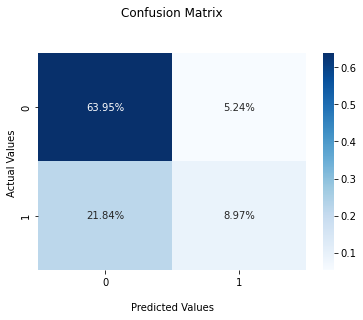

C:\Users\krist\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number 

Unscaled training set score: 0.6915
Unscaled test set score: 0.6919


C:\Users\krist\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
linear_svc_classifier(X_train,y_train, X_test,y_test)

In [15]:
def print_scores(grid):
    '''
    Prints out cross-validation accuracy, selected parameters, training set score and test set score.
    Makes a classification report. 
    
    '''
    # Report the best cross-validation accuracy and parameters
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    # Report the training set and test set scores
    print('Scaled training set score: {:.4f}'.format(grid.score(X_train,y_train)))
    print('Scaled Test set score: {:.4f}'.format(grid.score(X_test,y_test)))
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))

We could see that the liblinear fails to converge due to the absence of a scale.

Precision and recall:

1. precision: 

our model for pointed clients that didn't subscribe(0) has a 75% correct rate;

our model for pointed clients that subscribe(1) has a 63% correct rate

2. recall:

for test set clients that didn't subscribe(0), our model predicts 92% correct;

for test set clients that subscribe(1), our model predicts 29% correct. Its best we miss by False negative instead of False Positive

### Logistic Regression

In [18]:
def logistic_regression(X_train,y_train, X_test,y_test):
    ''' Logistic Regression using MinMaxScaler, GridSearchCV, and cross-validation for the wine datasets. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    Creates a confusion matrix.
    Also does creates the model without scaler and prints the results with using the unscaled data. 
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    
    # Grid Search and Pipeline
    param_grid = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100]}

    pipe = Pipeline([("scaler", MinMaxScaler()), ("lr", LogisticRegression(max_iter = 10000))]) # Create a pipeline with a scaler and a classifier
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)

    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))

    # Report the training set and test set scores
    print('Scaled training set score: {:.4f}'.format(grid.score(X_train,y_train)))
    print('Scaled Test set score: {:.4f}'.format(grid.score(X_test,y_test)))
    
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:',cf_matrix)
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');


    # Display the visualization of the Confusion Matrix.
    plt.show()
    
    # Grid search on unscaled data 
    param_grid2 = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    lr_unscaled = LogisticRegression() #try unscaled data
    grid2 = GridSearchCV(lr_unscaled, param_grid=param_grid2, cv=5)
    grid2.fit(X_train, y_train)

    print('Unscaled training set score: {:.4f}'.format(grid2.score(X_train,y_train)))
    print('Unscaled test set score: {:.4f}'.format(grid2.score(X_test,y_test)))

In [19]:
logistic_regression(X_train,y_train, X_test,y_test)

Best cross-validation accuracy: 0.73
Best parameters: {'lr__C': 100}
Scaled training set score: 0.7291
Scaled Test set score: 0.7320
              precision    recall  f1-score   support

          no       0.76      0.90      0.82      2969
         yes       0.61      0.35      0.45      1322

    accuracy                           0.73      4291
   macro avg       0.69      0.63      0.64      4291
weighted avg       0.71      0.73      0.71      4291



C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Unscaled training set score: 0.7111
Unscaled test set score: 0.6970


C:\Users\krist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We could see that the logistic regression fails to converge due to the absence of a scale.

Precision and recall:

1. precision: 

our model for pointed clients that didn't subscribe(0) has a 76% correct rate;

our model for pointed clients that subscribe(1) has a 61% correct rate

2. recall:

for test set clients that didn't subscribe(0), our model predicts 90% correct;

for test set clients that subscribe(1), our model predicts 35% correct. Its best we miss by False negative instead of False Positive

### K Neighbors

In [42]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

def k_neighbors_classifier(X_train,y_train, X_test,y_test):
    ''' K Neighbors Classifier using MinMaxScaler, GridSearchCV, and cross-validation for the wine datasets. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    Creates a confusion matrix.
    Also does creates the model without scaler and prints the results with using the unscaled data. 
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    
    
    # Grid Search and Pipeline
    param_grid = {'knn__n_neighbors': list(range(1,21))}

    pipe = Pipeline([("scaler", MinMaxScaler()), ("knn", KNeighborsClassifier())]) # Create a pipeline with a scaler and a classifier
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)

    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))

    # Report the training set and test set scores
    print('Scaled training set score: {:.4f}'.format(grid.score(X_train,y_train)))
    print('Scaled Test set score: {:.4f}'.format(grid.score(X_test,y_test)))

    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:',cf_matrix)
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');


    # Display the visualization of the Confusion Matrix.
    plt.show()
    
    knn_unscaled = KNeighborsClassifier() #try unscaled data
    param_grid2 = {'n_neighbors': list(range(1,21))}
    grid2 = GridSearchCV(knn_unscaled, param_grid=param_grid2, cv=5)
    grid2.fit(X_train, y_train)
    print('Unscaled training set score: {:.4f}'.format(grid2.score(X_train,y_train)))
    print('Unscaled test set score: {:.4f}'.format(grid2.score(X_test,y_test)))

Best cross-validation accuracy: 0.72
Best parameters: {'knn__n_neighbors': 20}
Scaled training set score: 0.7379
Scaled Test set score: 0.6868
              precision    recall  f1-score   support

          no       0.72      0.91      0.80      2969
         yes       0.48      0.19      0.27      1322

    accuracy                           0.69      4291
   macro avg       0.60      0.55      0.54      4291
weighted avg       0.64      0.69      0.64      4291

Confusion matrix: [[2699  270]
 [1074  248]]


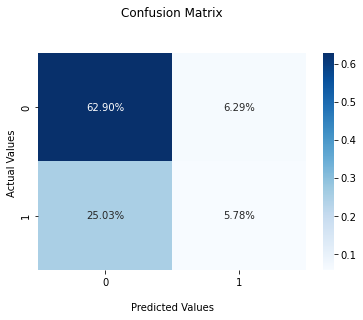

Unscaled training set score: 0.7038
Unscaled test set score: 0.6900


In [44]:
k_neighbors_classifier(X_train,y_train, X_test,y_test)

Precision and recall:

1. precision: 

our model for pointed clients that didn't subscribe(0) has a 72% correct rate;

our model for pointed clients that subscribe(1) has a 48% correct rate

2. recall:

for test set clients that didn't subscribe(0), our model predicts 91% correct;

for test set clients that subscribe(1), our model predicts 19% correct. Its best we miss by False negative instead of False Positive

### Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
def decision_tree(X_train,y_train, X_test,y_test):
    ''' Decision Tree Classifier using MinMaxScaler, GridSearchCV, and cross-validation for the wine datasets. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    Creates a confusion matrix.
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    # Grid Search
    param_grid = {'max_depth': [2,4,6,8,10],'max_features':[0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7]}
    tree = DecisionTreeClassifier()
    grid = GridSearchCV(tree, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train) 
    
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    
    # Report the training set and test set scores
    tree_score_train = grid.score(X_train, y_train)
    tree_score_test = grid.score(X_test, y_test)
    
    print("Training score: ",tree_score_train)
    print("Testing score: ",tree_score_test)
    
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:',cf_matrix)
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');


    ## Display the visualization of the Confusion Matrix.
    plt.show()

Best cross-validation accuracy: 0.75
Best parameters: {'max_depth': 6, 'max_features': 0.6}
Training score:  0.7593628593628594
Testing score:  0.754136564903286
              precision    recall  f1-score   support

          no       0.76      0.94      0.84      2969
         yes       0.71      0.34      0.46      1322

    accuracy                           0.75      4291
   macro avg       0.74      0.64      0.65      4291
weighted avg       0.75      0.75      0.72      4291

Confusion matrix: [[2784  185]
 [ 870  452]]


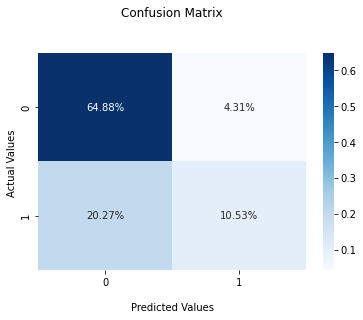

In [47]:
decision_tree(X_train,y_train, X_test,y_test)

Precision and recall:

1. precision: 

our model for pointed clients that didn't subscribe(0) has a 76% correct rate;

our model for pointed clients that subscribe(1) has a 71% correct rate

2. recall:

for test set clients that didn't subscribe(0), our model predicts 94% correct;

for test set clients that subscribe(1), our model predicts 32% correct. Its best we miss by False negative instead of False Positive

Apart from controlling for hyperparameters, it may be possible to avoid overfitting by
1. using classification metrics and stopping the cut if the next cut does not reduce the error
2. postpruning, where a decision tree is constructed (possibly overfitting), then some subtrees are removed and replaced with their leaves or nodes
3. bagging decision trees, using random forest



### RandomForest

In [48]:
from sklearn.ensemble import RandomForestClassifier
def random_forest(X_train,y_train, X_test,y_test):
    ''' Random Forest Classifier using MinMaxScaler, GridSearchCV, and cross-validation for the wine datasets. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    Creates a confusion matrix.
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''

    # Grid Search
    param_grid = {'max_depth': [2,4,8,10],'max_features':['auto', 'sqrt', 'log2'],'n_estimators':[100,200,300,400]}
    rfc = RandomForestClassifier()
    grid = GridSearchCV(rfc, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train) 
    
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    
    # Report the training set and test set scores
    rfc_score_train = grid.score(X_train, y_train)
    rfc_score_test = grid.score(X_test, y_test)
    print("Training score: ",rfc_score_train)
    print("Testing score: ",rfc_score_test)
    
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:',cf_matrix)
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');


    # Display the visualization of the Confusion Matrix.
    plt.show()

Best cross-validation accuracy: 0.75
Best parameters: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
Training score:  0.7823620823620824
Testing score:  0.752505243532976
              precision    recall  f1-score   support

          no       0.76      0.93      0.84      2969
         yes       0.70      0.34      0.46      1322

    accuracy                           0.75      4291
   macro avg       0.73      0.64      0.65      4291
weighted avg       0.74      0.75      0.72      4291

Confusion matrix: [[2774  195]
 [ 867  455]]


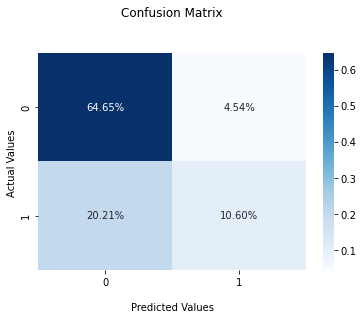

In [49]:
random_forest(X_train,y_train, X_test,y_test)

Precision and recall:

1. precision: 

our model for pointed clients that didn't subscribe(0) has a 76% correct rate;

our model for pointed clients that subscribe(1) has a 70% correct rate

2. recall:

for test set clients that didin't subscribe(0), our model predicts 93% correct;

for test set clients that subscribe(1), our model predicts 35% correct. Its best we miss by False negative instead of False Positive

How are decision tree classifiers different from random forests on a structural: decision trees are graphs that illustrate all possible outcomes of a decision using a branching approach. In contrast, the random forest algorithm output are a set of decision trees that work according to the output.

The decision tree:
1. the model is easy to interpret: we have a sight of the variable and their values that are used to split the data and are able to see the final model;
2. takes much less time than the random forest;

The random forest:
1. difficult to interpret since random forests involve multiple decision trees;
2. take a long time: more trees might improve performance, but also slow down the speed.
3. Random forests are helpful when the decision tree model is overfitting

In summary, the random forest is better if the decision tree is over-fitted, or when the runtime of the random forest is acceptable to us; the decision tree is better if we expect an interpretation of the model, or when the random forest takes too long.



# Part 3 Evaluation Metrics

The Accuracy, Macro and Micro-Averaged Precision & Recall, and F1 score is reported after running each of the functions that were made. 

Accuracy of the training and test sets are printed in seperate lines. 

Macro and Micro-Averaged Precision & Recal and F1 scores can be seen in the classification report table. 


Analysis on what these scores mean for the models under consideration: 
    
    Accuracy. 
    From the machine learning models that we tried out, the Random Forest Classifier preformed the best based on the 
    accuracy score. (0.752) 
    The Linear SVC, Linear Regression, and Decision Tree classifier all preformed similarly. (~ 0.73)
    K Neighbors Classifier preformed the worst. (0.689)
    
    False positives and false negatives. 
    If you wanted to have the least amount of false negatives, you should choose the Decision Tree.
    If flase positives are the most costly, going with the Random Forest would be the best.